# Exercise 4 $\Longrightarrow$ AirBnB


- James D. Gaboardi
- Filiberto Asare-Akuffo
----
     
     GNU LESSER GENERAL PUBLIC LICENSE
         Version 3, 29 June 2007

     Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
     Everyone is permitted to copy and distribute verbatim copies
     of this license document, but changing it is not allowed.


----

## Austin, Texas

In [20]:
import geopandas as gpd
import sys
import pysal as ps
import numpy as np
import pandas as pd
from scipy.stats import zscore
import time


import dask.dataframe as dd
import dask.array as da
from dask import delayed

%matplotlib inline

In [21]:
top_directory = "/Users/jgaboardi/Desktop/FSU/FSU_school_work_CPU/"\
                +"Fall_16/Smart_Cities/Exercises/Exercise_4"

# Data Directories
raw_data = top_directory+"/raw_data"
clean_data = top_directory+"/clean_data"

# Study Area

#### I keep the census tracts in the Austin,TX MSA that contained at least one AirBnB and disguarded the remainder

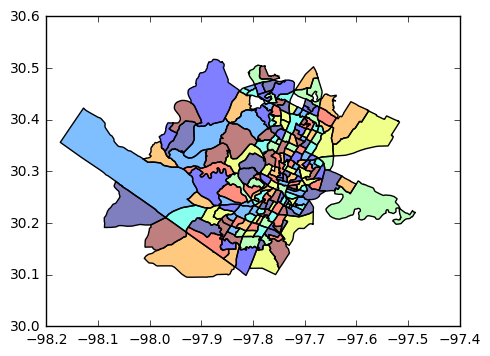

In [49]:
tract_shapes = gpd.read_file(clean_data+"/StudyAreaTracts.shp")
tract_shapes.plot()

## Variable Calculation

### ACS Variables

In [22]:
acs_data = pd.read_csv(clean_data+"/StudyAreaData.csv")

calculated_acs_variables = pd.DataFrame(acs_data.GISJOIN)

- **transportation**: accessibility to public transportation
    - ***computed as***: proportion of commuters who get to work by transit

In [23]:
trans_columns = ["ABBRE001", # Total Means of Transportation to Work
                 "ABBRE010", # Public transit
                 "ABBRE021"] # Work at home
trans_df = acs_data[trans_columns].copy()
trans_df["transit"] = trans_df.sum(axis=1) - trans_df.ABBRE001 - trans_df.ABBRE021
trans_df["transportation"] = trans_df["transit"]/(trans_df.ABBRE001 - trans_df.ABBRE021)
calculated_acs_variables["transportation"] = trans_df["transportation"]

- **young**
    - ***computed as***: proportion of population between 20 and 34 years old

In [24]:
young_columns = ["ABAQE001", # Total
                 "ABAQE008", # Male: 20 years 
                 "ABAQE009", # Male: 21 years
                 "ABAQE010", # Male: 22 to 24 years
                 "ABAQE011", # Male: 25 to 29 years
                 "ABAQE012", # Male: 30 to 34 years
                 "ABAQE032", # Female: 20 years
                 "ABAQE033", # Female: 21 years
                 "ABAQE034", # Female: 22 to 24 years
                 "ABAQE035", # Female: 25 to 29 years
                 "ABAQE036"] # Female: 30 to 34 years
young_df = acs_data[young_columns].copy()
young_df["20_34"] = young_df.sum(axis=1) - young_df.ABAQE001
young_df["young"] = young_df["20_34"]/young_df.ABAQE001
calculated_acs_variables["young"] = young_df["young"]

- **income**
    - ***computed as***: median household income

In [25]:
calculated_acs_variables["income"] = acs_data["ABDPE001"] # Median HH Income

- **employment**
    - ***computed as***: employed persons as a share of population 16 and older

In [26]:
employment_columns = ["ABAQE001", # Total Population
                      "ABGFE004"] # Employed People
employment_df = acs_data[employment_columns].copy()
employment_df["employment"] = employment_df.ABGFE004 / employment_df.ABAQE001
calculated_acs_variables["employment"] = employment_df["employment"]

- **bohemian**: Based on the work of Richard Florida, the idea that people in the “creative class” contribute disproportionately to the health of a city has been widely studied. There have been a number of variations on defining his group.
    - ***computed as***: proportion of the employed residents working in the “Arts, Design, Entertainment, Sports, And Media Occupations.”

In [27]:
bohemia_columns = ["ABGSE001", # Total Occupation
                   "ABGSE015", # Male Arts
                   "ABGSE051"] # Female Arts
bohemia_df = acs_data[bohemia_columns].copy()
bohemia_df["bohemia"] = (bohemia_df.ABGSE015 
                         + bohemia_df.ABGSE051)/bohemia_df.ABGSE001
calculated_acs_variables["bohemia"] = bohemia_df["bohemia"]

- **melting pot**
    - ***computed as***: proportion of total population born outside the US

In [28]:
foreign_columns = ["ABL8E001", # Foreign-born
                   "ABAQE001"] # US-born
foreign_df = acs_data[foreign_columns].copy()
foreign_df["melting_pot"] = foreign_df.ABL8E001/foreign_df.ABAQE001
calculated_acs_variables["melting_pot"] = foreign_df["melting_pot"]

- **education**
     - ***computed as***: proportion or residents 25 and over with masters or higher

In [29]:
#edu_columns = ["ABC4E"+str(9000+bracket)[1:] for bracket in range(1, 25+1)]
edu_columns = ["ABC4E001", # Total Edu. attainment over 25 yrs.
               "ABC4E023", # Master's degree
               "ABC4E024", # Professional school degree
               "ABC4E025"] # Doctorate degree
edu_df = acs_data[edu_columns].copy()
edu_df[">MS"] = edu_df.sum(axis=1) - edu_df.ABC4E001
edu_df["education"] = edu_df[">MS"]/edu_df.ABC4E001
calculated_acs_variables["education"] = edu_df["education"]

- **substandard**: quality of living and housing that can be considered substandard
    - ***computed as***: proportion of occupied housing units with three or four “selected conditions”

In [30]:
substandard_columns = ["ABZKE001", # Total occupied
                       "ABZKE005", # Owner occupied: With three selected conditions 
                       "ABZKE006", # Owner occupied: With four selected conditions
                       "ABZKE011", # Renter occupied: With three selected conditions
                       "ABZKE012"] # Renter occupied: With four selected conditions
substandard_df = acs_data[substandard_columns].copy()
substandard_df["substd"] = substandard_df.sum(axis=1) - substandard_df.ABZKE001
substandard_df["substandard"] = substandard_df["substd"]/substandard_df.ABZKE001
calculated_acs_variables["substandard"] = substandard_df["substandard"]

- **multifamily**
     - ***computed as***: share of housing units in buildings of 3 or more units

In [31]:
multifam_columns = ["ABHME001", # Total units
                    "ABHME005", # 3 or 4
                    "ABHME006", # 5 to 9
                    "ABHME007", # 10 to 19
                    "ABHME008", # 20 to 49
                    "ABHME009"] # 50 or more
multifam_df = acs_data[multifam_columns].copy()
multifam_df["multi"] = multifam_df.sum(axis=1) - multifam_df.ABHME001
multifam_df["multifamily"] = multifam_df["multi"]/multifam_df.ABHME001
calculated_acs_variables["multifamily"] = multifam_df["multifamily"]

- **rental**
    - ***computed as***: share of occupied housing units rented

In [32]:
rental_columns = ["ABGXE001", # Total occupied
                  "ABGXE003"] # Renter occupied
rental_df = acs_data[rental_columns].copy()                 
rental_df["rental"] = rental_df.ABGXE003/rental_df.ABGXE001
calculated_acs_variables["rental"] = rental_df["rental"]

- **fancy**: high-end housing
     - ***computed as***: percent of owner occupied homes approximately 2 times or more the region median value based on Kiplinger. Table B25075 has discrete bins so the cutoff needs to be estimated.

In [33]:
def roundup(x):
    return int(np.ceil(x / 100000.0)) * 100000

austin_med_sale_price = 225000.
high_end_price = austin_med_sale_price*2
high_end_bin = roundup(high_end_price)
high_end_bin

500000

In [34]:
fancy_columns = ["ABIRE001", # Total Owner-occupied housing units
                 "ABIRE023", # $500,000 to $749,999
                 "ABIRE024", # $750,000 to $999,999
                 "ABIRE025"] # $1,000,000 or more
fancy_df = acs_data[fancy_columns].copy()
fancy_df[">high_end_bin"] = fancy_df.sum(axis=1) - fancy_df.ABIRE001
fancy_df["fancy"] = fancy_df[">high_end_bin"]/fancy_df.ABIRE001
calculated_acs_variables["fancy"] = fancy_df["fancy"]

- **house price**
    - ***computed as***: median home value

In [35]:
calculated_acs_variables["house_price"] = acs_data["ABITE001"] # Median Home Value

- **Simpson Diversity Index**

### $ \displaystyle D = 1 - \sum^5_{g=1} p^2_g $

In [36]:
def simpson(dataframe):
    D = [(1. - np.array([np.square(race_df.iloc[record][group]/race_df.iloc[record].Totals)\
                         for group in race_df if group != "Totals"]).sum())\
                         for record in range(len(dataframe))]
    dataframe["Simpson"] = D
    return dataframe

### example ###
race_df = pd.DataFrame()
white = [800.]
black = [1000.]
asian = [500.]
other = [400.]
hispanic = [1300.]
race_df["White"] = white
race_df["Black"] = black
race_df["Asian"] = asian
race_df["Other"] = other
race_df["Hispanic"] = hispanic
race_df["Totals"] = race_df.sum(axis=1)
simpson(race_df)
race_df.Simpson # Should return approx. 0.766

0    0.76625
Name: Simpson, dtype: float64

In [37]:
race_columns = ["ABBAE"+str(9000+bracket)[1:] for bracket in range(1, 21+1)]
pre_race_df = acs_data[race_columns].copy()
race_df = pd.DataFrame()
race_df["Totals"] = pre_race_df.ABBAE001.astype(float) # Total 
race_df["White"] = pre_race_df.ABBAE003.astype(float)  # White (not hisp)
race_df["Black"] = pre_race_df.ABBAE004.astype(float)  # Black (not hisp)
race_df["Asian"] = pre_race_df.ABBAE006.astype(float)  # Asian (not hisp)
race_df["Other"] = pre_race_df.ABBAE005.astype(float)\
                    + pre_race_df.ABBAE007.astype(float)\
                    + pre_race_df.ABBAE008.astype(float)\
                    + pre_race_df.ABBAE009.astype(float)\
                    + pre_race_df.ABBAE010.astype(float)\
                    + pre_race_df.ABBAE011.astype(float) # All other (not hisp)
race_df["Hispanic"] = pre_race_df.ABBAE012.astype(float) # Hispanis
simpson(race_df)
calculated_acs_variables["Simpson"] = race_df["Simpson"] # Simpson Diversity Index

In [140]:
calculated_acs_variables.to_csv(clean_data+"/calculated_acs_variables.csv")
calculated_acs_variables.head()

,GISJOIN,transportation,young,income,employment,bohemia,melting_pot,education,substandard,multifamily,rental,fancy,house_price,Simpson
0,G4802090010100,0.007529,0.540023,27315.0,0.553927,0.068493,0.044720,0.140044,0.0,0.547833,0.731746,0.100592,158500.0,0.501421
1,G4802090010200,0.000000,0.250507,25429.0,0.250691,0.078818,0.039078,0.148536,0.0,0.420755,0.725581,0.000000,146900.0,0.508790
2,G4802090010302,0.000000,0.387294,34010.0,0.483156,0.000000,0.068506,0.035699,0.0,0.377157,0.719028,0.000000,81900.0,0.467312
3,G4802090010303,0.044884,0.628545,29945.0,0.509191,0.013986,0.073398,0.044628,0.0,0.658652,0.764684,0.000000,56700.0,0.597330
4,G4802090010304,0.082803,0.560688,20752.0,0.493659,0.000000,0.058122,0.025144,0.0,0.798106,0.884047,0.000000,93300.0,0.580127


### GeoNames Variables

In [ ]:
interest = gpd.read_file(clean_data+"/StudyAreaInterest.shp")

- **hot_supply**: hotels per square mile (feature code: HTL)

In [44]:
# 1 Sq. Meter = 0.000000386102159 Sq. Mile
hotels = interest[interest.field_8 == "HTL"]
hotels.to_file(clean_data+"/StudyAreaHotels.shp")

- **attractions**: attractions per square mile (not all points are “attractions” so consider which feature codes to use)

In [ ]:
attraction_list = ["AMUS", # amusement park
                   "CMN", # common a park
                   "PRK", # park
                   "PRMN", # promenade
                   "RDA", # ancient road
                   "AMTH", # amphitheater
                   "ANS", # archaeological/prehistoric site
                   "BUR", # burial cave(s)
                   "CARN", # cairn
                   "CMP", # camp(s)
                   "CSNO", # casino
                   "CSTL", # castle
                   "CTRS", # space center
                   "MFGB", # brewery
                   "MNMT", # monument
                   "OPRA", # opera house
                   "PAL", # palace
                   "PGDA", # pagoda
                   "RECG", # golf course
                   "RECR", # racetrack
                   "RSRT", # resort
                   "RUIN", # ruin(s)
                   "SHRN", # shrine
                   "SPA", # spa
                   "SQR", # square
                   "THTR", # theater
                   "ZOO", # zoo
                   "FRSTF", # fossilized forest
                   "VIN", # vineyard
                   "VINS"] # vineyards

In [58]:
# 1 Sq. Meter = 0.000000386102159 Sq. Mile
attractions = interest[interest["field_8"].isin(attraction_list)]
attractions.to_file(clean_data+"/StudyAreaAttractions.shp")

### AirBnB Variables

In [ ]:
airBnB = gpd.read_file(clean_data+"/Austin_AirBnB.shp")

- **air_supply**: Airbnb properties per square mile
- **air_unit**: Airbnb “Entire home/apt” properties per square mile
- **air_room**: Airbnb “Room” properties per square mile
- **air_demand**: Airbnb reviews per square mile (this is a proxy for number of rentals)

In [64]:
airBnB_units = airBnB[airBnB.room_type == "Entire home/apt"]
airBnB_rooms = airBnB[airBnB.room_type.isin(["Shared room", "Private room"])]

In [66]:
airBnB_units.to_file(clean_data+"/airBnB_units.shp")
airBnB_rooms.to_file(clean_data+"/airBnB_rooms.shp")

## Standardize the data

In [68]:
tract_shapes = gpd.read_file(clean_data+"/StudyAreaTracts.shp")

In [78]:
variables_list = ["transportation",
                  "young",
                  "income",
                  "employment",
                  "bohemia",
                  "melting_pot",
                  "education",
                  "substandard",
                  "multifamily",
                  "rental",
                  "fancy",
                  "house_price",
                  "Simpson",
                  "hot_supply",
                  "attraction",
                  "air_supply",
                  "air_unit",
                  "air_room",
                  "air_demand"]

### Calculated variables dataframe

In [135]:
tract_variabes_df = tract_shapes[variables_list].copy()
tract_variabes_df = gpd.GeoDataFrame(tract_variabes_df)
tract_variabes_df['geometry'] = tract_shapes.geometry
tract_variabes_df.to_file(clean_data+"/tract_variabes_df.shp")

### $\displaystyle \log(n)$ dataframe

In [136]:
tract_variabes_df_logged = tract_shapes[variables_list].copy()
tract_variabes_df_logged = tract_variabes_df_logged.apply(np.log)
tract_variabes_df_logged = tract_variabes_df_logged.fillna(0.0)
tract_variabes_df_logged = tract_variabes_df_logged.replace(np.inf*-1, 0.0)
tract_variabes_df_logged = gpd.GeoDataFrame(tract_variabes_df_logged)
tract_variabes_df_logged['geometry'] = tract_shapes.geometry
tract_variabes_df_logged.to_file(clean_data+"/tract_variabes_df_logged.shp")

### $\displaystyle z-score$ dataframe

In [159]:
tract_variabes_df_zscore = tract_variabes_df_logged[variables_list].copy()
tract_variabes_df_zscore = pd.DataFrame(zscore(tract_variabes_df_zscore))
tract_variabes_df_zscore = gpd.GeoDataFrame(tract_variabes_df_zscore)
tract_variabes_df_zscore.columns = variables_list
tract_variabes_df_zscore['GISJOIN'] = tract_shapes.GISJOIN
tract_variabes_df_zscore['geometry'] = tract_variabes_df_logged.geometry
tract_variabes_df_zscore.to_file(clean_data+"/tract_variabes_df_zscore.shp")

--------------------------